In [737]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/Stock/new_msft.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()
#spark = pyspark.sql.SparkSession.builder.master("local").appName("StockMarket").config("spark.executor.memory", "6gb").getOrCreate()
#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)

# Analyse data

In [738]:
#transform Date column by removing timestamp
import pyspark.sql.functions as f
df = df.withColumn('date', f.to_date('Date'))

date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])
df.show(n=10)

+---+----------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------------------+----+-----+---+
|_c0|      date|              Open|              High|               Low|             Close|         Adj Close|  Volume|     Type|            Polarity|year|month|day|
+---+----------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------------------+----+-----+---+
|  0|2016-01-04|             54.32|         54.799999|53.389998999999996|         54.799999|         50.398834|53778000|microsoft| 0.13001905101690225|2016|   01| 04|
|  1|2016-01-05|             54.93|55.389998999999996|54.540001000000004|         55.049999|         50.628761|34079700|microsoft| 0.12435434924261228|2016|   01| 05|
|  2|2016-01-06|             54.32|         54.400002|53.639998999999996|         54.049999|         49.709072|39518900|microsoft|0.046524003467785034|2016|   01| 06

In [739]:
#create three additional columns 
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])
df.show(n=10)
type(df)

df1 = df.select('Close')
df1.show(n=10)

+---+----------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------------------+----+-----+---+
|_c0|      date|              Open|              High|               Low|             Close|         Adj Close|  Volume|     Type|            Polarity|year|month|day|
+---+----------+------------------+------------------+------------------+------------------+------------------+--------+---------+--------------------+----+-----+---+
|  0|2016-01-04|             54.32|         54.799999|53.389998999999996|         54.799999|         50.398834|53778000|microsoft| 0.13001905101690225|2016|   01| 04|
|  1|2016-01-05|             54.93|55.389998999999996|54.540001000000004|         55.049999|         50.628761|34079700|microsoft| 0.12435434924261228|2016|   01| 05|
|  2|2016-01-06|             54.32|         54.400002|53.639998999999996|         54.049999|         49.709072|39518900|microsoft|0.046524003467785034|2016|   01| 06

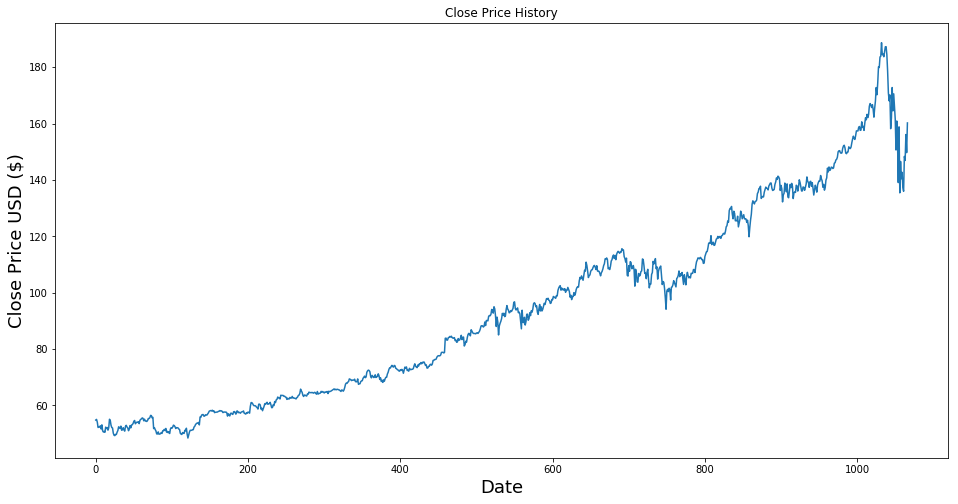

In [740]:
#Sava a subset of spark dataframe to pandas dataframe and plot it.
## Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_plot = df.select('Close').toPandas()
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_plot["Close"])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# Get LSTM input

In [741]:
#Create a new dataframe with only the 'Close' column, convert it to np array
#dataset = np.array(df.select('Close').collect())
data = df.select('Close','Polarity').toPandas()
#Converting the dataframe to a numpy array
dataset = data.to_numpy()
print(len(dataset))

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Create the scaled training data set and test data set
train_data = dataset[0:training_data_len]
test_data = dataset[training_data_len - 10:]

print(train_data[0], len(train_data))
print('-------------')
print(test_data[0], len(test_data))

1067
[54.799999    0.13001905] 854
-------------
[123.349998     0.12608131] 223


In [742]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print(scaled_train_data[0])
#print(scaled_train_data[9])
#print(scaled_train_data[10])
print('-------------')
print(scaled_test_data[0])

[0.07752219 0.56658928]
-------------
[0.05097302 0.47185359]


In [743]:
#previous 10 days close price + today's sentiment scores
y_train = scaled_train_data[10:len(scaled_train_data),0]
type(y_train)

x_train=[]
for i in range(10,len(scaled_train_data)):
    #previous 10 days close price and today sentiment scores
    features = []
    features.extend(scaled_train_data[i-10:i,0])#previous close data, not include today's close i
    features.append(scaled_train_data[i][1])#sentiment scores 
    x_train.append(features)
    
#convert list to np array
x_train = np.array(x_train)

print(x_train[0])
print('-------------')
print(y_train[0])    

[0.07752219 0.08056466 0.06839477 0.04551537 0.0474626  0.04709747
 0.05293901 0.03906534 0.0569551  0.03115494 0.46991463]
-------------
0.025921879572456175


In [744]:
#previous 10 days close price + today's sentiment scores
y_test = scaled_test_data[10:len(scaled_test_data), 0]
x_test=[]
for i in range(10, len(scaled_test_data)):
    features = []
    features.extend(scaled_test_data[i-10:i,0])
    #features.append(scaled_test_data[i-10:i,0])
    features.append(scaled_test_data[i][1])  
    x_test.append(features) 
x_test = np.array(x_test)
print(x_test[0])
print('-------------')
print(y_test[0]) 


[0.05097302 0.07101375 0.08974733 0.13200693 0.11951802 0.09265183
 0.10252695 0.113709   0.09207093 0.09294223 0.51459557]
-------------
0.09178053889368964


In [745]:

print('x_train shape = {}'.format(x_train.shape))
print('y_train shape = {}'.format(y_train.shape))
print('x_test shape = {}'.format(x_test.shape))
print('y_test shape = {}'.format(y_test.shape))

x_train shape = (844, 11)
y_train shape = (844,)
x_test shape = (213, 11)
y_test shape = (213,)


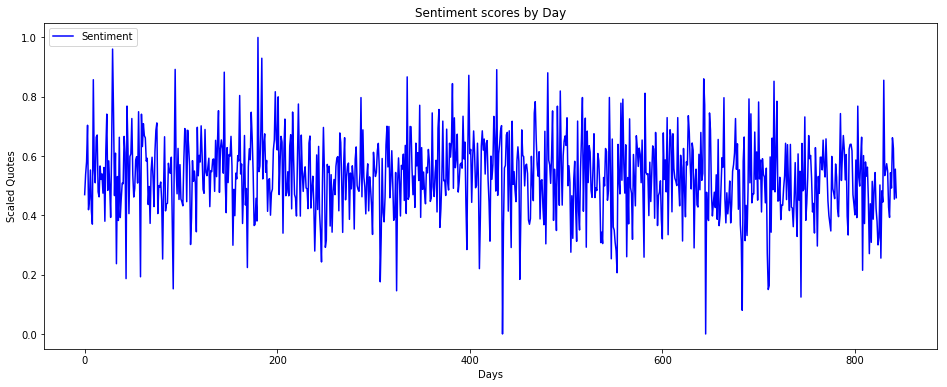

In [746]:
plt.figure(figsize=(16,6))
plt.plot(x_train[:,-1:],color='blue', label='Sentiment')
plt.legend(loc = 'upper left')
plt.title('Sentiment scores by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

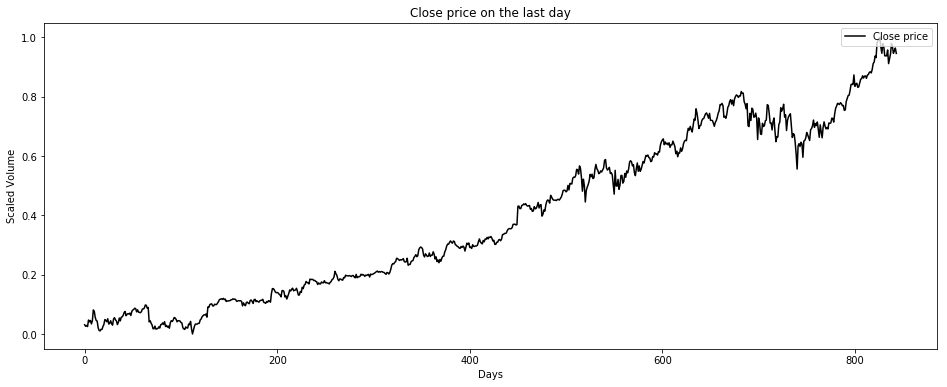

In [747]:
plt.figure(figsize=(16,6))
plt.plot(x_train[:,9],color='black', label='Close price')
plt.legend(loc = 'upper right')
plt.title('Close price on the last day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

#  Train LSTM Model

In [748]:
from keras import models, layers

In [749]:
#Reshape the data into the shape accepted by the LSTM:3D
x_train = np.reshape(x_train, (x_train.shape[0],1, x_train.shape[1]))
x_test  = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


print('The shape of x_train is {}: '.format(x_train.shape))
print('The shape of x_test is {}: '.format(x_test.shape))


#Build the LSTM network model
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,11)))
model.add(layers.Dense(1))
##Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

The shape of x_train is (844, 1, 11): 
The shape of x_test is (213, 1, 11): 


In [750]:
##Train the model
loss = model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
844/844 [==============================] - 1s 621us/step - loss: 0.1926
Epoch 2/100
844/844 [==============================] - 0s 168us/step - loss: 0.1135
Epoch 3/100
844/844 [==============================] - 0s 178us/step - loss: 0.0675
Epoch 4/100
844/844 [==============================] - 0s 164us/step - loss: 0.0481
Epoch 5/100
844/844 [==============================] - 0s 164us/step - loss: 0.0373
Epoch 6/100
844/844 [==============================] - 0s 162us/step - loss: 0.0287
Epoch 7/100
844/844 [==============================] - 0s 161us/step - loss: 0.0212
Epoch 8/100
844/844 [==============================] - 0s 164us/step - loss: 0.0149
Epoch 9/100
844/844 [==============================] - 0s 168us/step - loss: 0.0103
Epoch 10/100
844/844 [==============================] - 0s 166us/step - loss: 0.0073
Epoch 11/100
844/844 [==============================] - 0s 164us/step - loss: 0.0056
Epoch 12/100
844/844 [==============================] - 0s 163us/step - lo

844/844 [==============================] - 0s 161us/step - loss: 5.6092e-04
Epoch 95/100
844/844 [==============================] - 0s 152us/step - loss: 5.7715e-04
Epoch 96/100
844/844 [==============================] - 0s 152us/step - loss: 5.4602e-04
Epoch 97/100
844/844 [==============================] - 0s 156us/step - loss: 5.5710e-04
Epoch 98/100
844/844 [==============================] - 0s 154us/step - loss: 5.4827e-04
Epoch 99/100
844/844 [==============================] - 0s 152us/step - loss: 5.4268e-04
Epoch 100/100
844/844 [==============================] - 0s 155us/step - loss: 5.5197e-04


In [751]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
print(predictions)

[[0.09567291]
 [0.1006268 ]
 [0.0607864 ]
 [0.09945726]
 [0.09739727]
 [0.02932358]
 [0.04479727]
 [0.08750919]
 [0.08730918]
 [0.18278615]
 [0.22882119]
 [0.18913546]
 [0.21748677]
 [0.20241955]
 [0.14841846]
 [0.16701098]
 [0.19124559]
 [0.21015443]
 [0.23264551]
 [0.27061427]
 [0.2607522 ]
 [0.2242948 ]
 [0.19446212]
 [0.19158214]
 [0.1576998 ]
 [0.19852254]
 [0.24889511]
 [0.23585454]
 [0.26946908]
 [0.2815584 ]
 [0.2371092 ]
 [0.24419594]
 [0.25797808]
 [0.25802806]
 [0.27414203]
 [0.2588032 ]
 [0.23614539]
 [0.23454529]
 [0.22674003]
 [0.23652765]
 [0.2790068 ]
 [0.29256532]
 [0.31603166]
 [0.32583353]
 [0.3196372 ]
 [0.29544187]
 [0.25299758]
 [0.22845817]
 [0.22871482]
 [0.16804788]
 [0.191957  ]
 [0.21871114]
 [0.20749103]
 [0.30336356]
 [0.28409418]
 [0.24612087]
 [0.25288802]
 [0.18659651]
 [0.2229468 ]
 [0.21773344]
 [0.21541835]
 [0.31370384]
 [0.28307444]
 [0.20020413]
 [0.23215939]
 [0.22378492]
 [0.16362481]
 [0.2462725 ]
 [0.28876972]
 [0.21674983]
 [0.27849048]
 [0.30

# Error analysis 

In [752]:
#Calculate/Get the value of RMSE
#rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
from pyspark.ml.evaluation import RegressionEvaluator

df = pd.DataFrame(y_test, columns=['Close'])
df['Predict'] = predictions
print(df)
df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="rmse")
rmse = rmse_evaluator.evaluate(df_predictions)

mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="mse")
mse = mse_evaluator.evaluate(df_predictions)

mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predict", metricName="mae")
mae = mae_evaluator.evaluate(df_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Square Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)



        Close   Predict
0    0.091781  0.095673
1    0.074063  0.100627
2    0.085536  0.060786
3    0.055765  0.099457
4    0.000000  0.097397
..        ...       ...
208  0.413883  0.418686
209  0.393262  0.290226
210  0.526721  0.380434
211  0.433633  0.576968
212  0.586552  0.556001

[213 rows x 2 columns]
Root Mean Squared Error (RMSE) on test data = 0.062043
Mean Square Error (MSE) on test data = 0.00384934
Mean Absolute Error (MAE) on test data = 0.0401291


In [753]:
#Undo scaling, show real prediction
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 2) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

# Result visualization

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


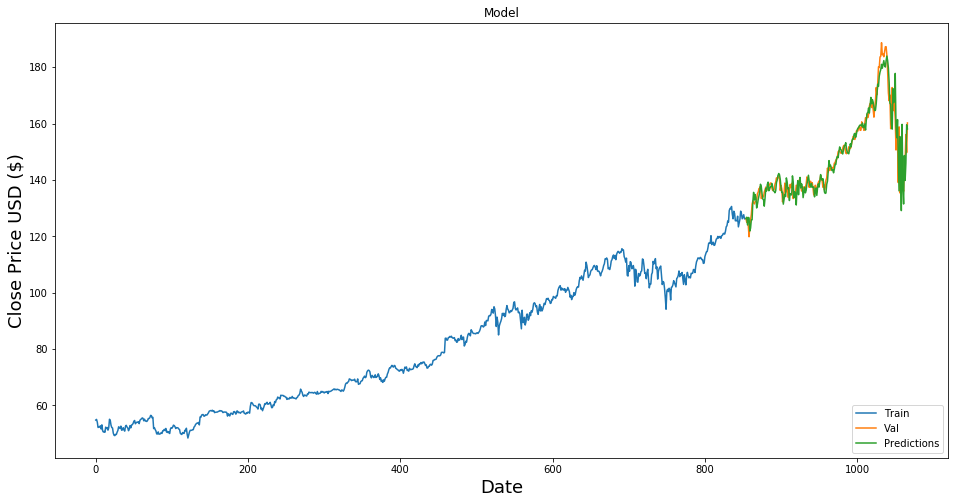

In [754]:
#Plot/Create the data for the graph
#train = data[:training_data_len]
#valid = data[training_data_len:]
train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [755]:
#Show the valid and predicted prices
valid

,Close,Polarity,Predictions
854,126.160004,0.137502,126.428032
855,124.940002,0.101932,126.769157
856,125.730003,0.155022,124.025747
857,123.680000,0.078272,126.688623
858,119.839996,0.102916,126.546772
...,...,...,...
1062,148.339996,0.101711,148.670702
1063,146.919998,0.125105,139.824990
1064,156.110001,0.085639,146.036682
1065,149.699997,0.146739,159.570043


# Predict the newest day

In [756]:
#predict next day
#Get the quote
#msft_quote = pd.read_csv("MSFT.csv")

fileName = "/Users/lingzhuo/Desktop/256/Stock/new_msft.csv"

#spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()

msft_quote = spark.read.csv(fileName, header=True, inferSchema=True)

#Create a new dataframe
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
new_df = msft_quote.select('Close','Polarity').toPandas()

#Get teh last 10 day closing price and today's sentimen scores, create an empty list and append the past 10 day price to it, 
#and then convert it to a numpy array and reshape it so that I can input the data into the model.
new_df = new_df.to_numpy()
X_test = []

last_10_days = []
last_10_days.extend(new_df[-11:-1,0])#exclude today
last_10_days.append(new_df[-1][1])# today sentiment

X_test.append(last_10_days)
X_test = np.array(X_test)
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#X_test_scaled = scaler.transform(X_test)

#Get the predicted scaled price
predictions = model.predict(X_test)
#undo the scaling 
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 2) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
print(predictions)




[203.66749847]
